Predikcija kreditnog rizika - Home Credit Default Risk

Cilj ovog projekta je da se razvije model mašinskog učenja koji predviđa verovatnoću da klijent ne otplati kredit (promenljiva TARGET: 1 = klijent je u problemu sa otplatom, 0 = klijent uredno vraća kredit).

Ovaj problem je klasičan primer binarne klasifikacije sa neuravnoteženim klasama – daleko više je klijenata koji vraćaju kredit nego onih koji ne vraćaju. Zbog toga sama tačnost (accuracy) nije dovoljna mera uspeha, već se naglasak stavlja na ROC-AUC metriku, jer pokazuje kako se ponaša model kada se menja prag (threshold) tj. koliko je dobar u razlikovanju klasa.

In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pandas.core.algorithms as algos
import scipy.stats.stats as stats
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from sklearn.neural_network import MLPClassifier
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

application_{train|test}.csv

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

In [305]:
df_train = pd.read_csv('data/application_train.csv')
df_test  = pd.read_csv("data/application_test.csv")
df_train.head()
print("Ima {} observacija i {} kolona u ovom dataset-u. \n".format(df_train.shape[0], df_train.shape[1]))

Ima 307511 observacija i 122 kolona u ovom dataset-u. 



In [447]:
test_ids = df_test["SK_ID_CURR"].values

In [448]:
test_ids

array([100001, 100005, 100013, ..., 456223, 456224, 456250])

NA - pregled nedostajucih vrednosti

In [306]:
missing = df_train.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Kolone sa najviše nedostajućih vrednosti:\n", missing.head(20))

Kolone sa najviše nedostajućih vrednosti:
 COMMONAREA_MEDI             214865
COMMONAREA_MODE             214865
COMMONAREA_AVG              214865
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_MEDI    213514
NONLIVINGAPARTMENTS_AVG     213514
FONDKAPREMONT_MODE          210295
LIVINGAPARTMENTS_AVG        210199
LIVINGAPARTMENTS_MEDI       210199
LIVINGAPARTMENTS_MODE       210199
FLOORSMIN_MEDI              208642
FLOORSMIN_MODE              208642
FLOORSMIN_AVG               208642
YEARS_BUILD_MODE            204488
YEARS_BUILD_MEDI            204488
YEARS_BUILD_AVG             204488
OWN_CAR_AGE                 202929
LANDAREA_AVG                182590
LANDAREA_MEDI               182590
LANDAREA_MODE               182590
dtype: int64


In [307]:
df_train = df_train.dropna(how='all') # Remove all rows with NULL values from the DataFrame.
df_train.shape

(307511, 122)

In [308]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [309]:
df_train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

Analiza podataka

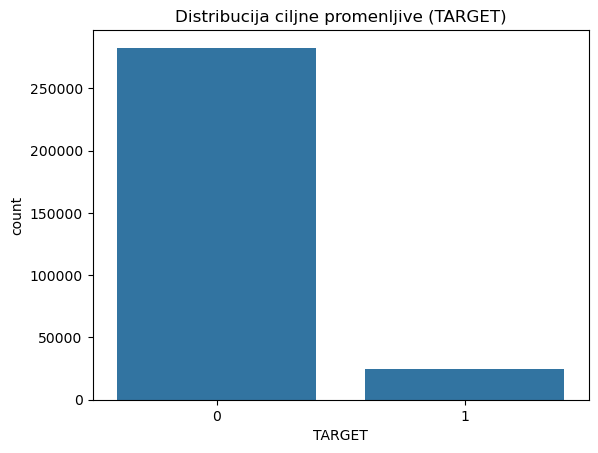

In [310]:
sns.countplot(x="TARGET", data=df_train)
plt.title("Distribucija ciljne promenljive (TARGET)")
plt.show()

Zbog toga što je ciljna promenljiva nebalansirana tj. ima mnogo više onih koji nemaju poteškoća u plaćanju kredita od onih koji imaju, meru kao što je Accuracy ne smatramo relevantnom. Ako bismo npr. predvideli da svi otplate kredit (svi 0) onda bismo opet imali veliku tačnost (preko 90%).

In [311]:
print(df_train["TARGET"].value_counts(normalize=True))

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


In [312]:
print(df_train["NAME_CONTRACT_TYPE"].value_counts(normalize=True))

NAME_CONTRACT_TYPE
Cash loans         0.904787
Revolving loans    0.095213
Name: proportion, dtype: float64


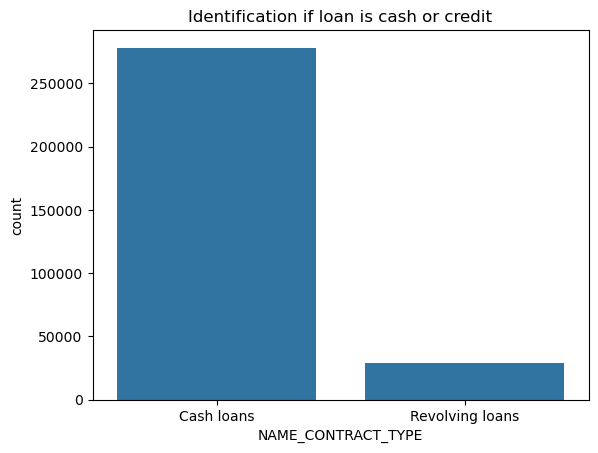

In [313]:
sns.countplot(x="NAME_CONTRACT_TYPE", data=df_train)
plt.title("Identification if loan is cash or credit")
plt.show()

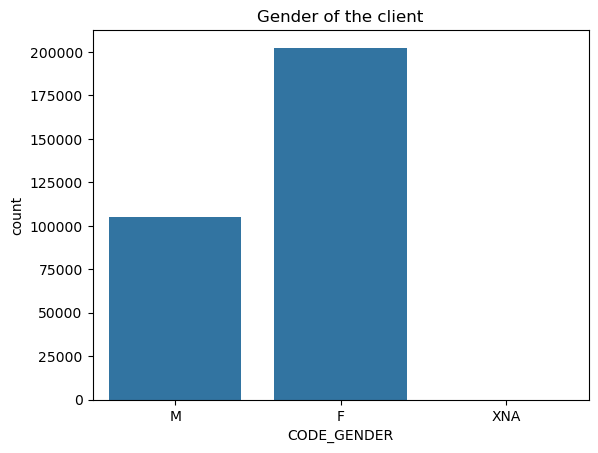

In [314]:
sns.countplot(x="CODE_GENDER", data=df_train)
plt.title("Gender of the client")
plt.show()

In [315]:
print(df_train["CODE_GENDER"].value_counts(normalize=True))

CODE_GENDER
F      0.658344
M      0.341643
XNA    0.000013
Name: proportion, dtype: float64


Oko 65% čine žene.

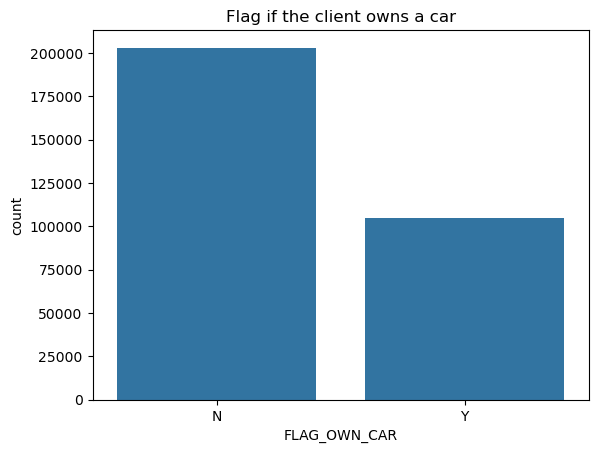

In [316]:
sns.countplot(x="FLAG_OWN_CAR", data=df_train)
plt.title("Flag if the client owns a car")
plt.show()

In [317]:
print(df_train["FLAG_OWN_CAR"].value_counts(normalize=True))

FLAG_OWN_CAR
N    0.659892
Y    0.340108
Name: proportion, dtype: float64


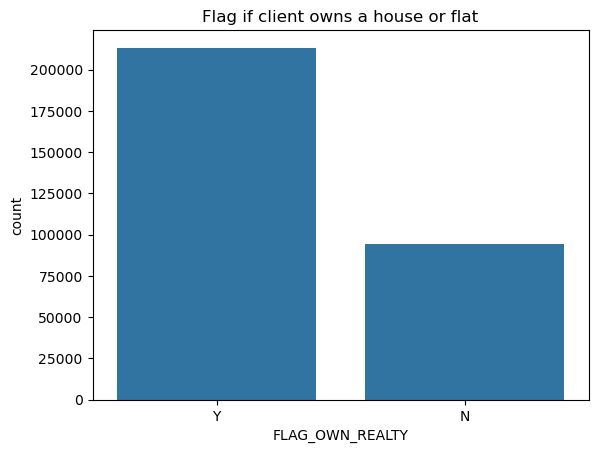

In [318]:
sns.countplot(x="FLAG_OWN_REALTY", data=df_train)
plt.title("Flag if client owns a house or flat")
plt.show()

In [319]:
print(df_train["FLAG_OWN_REALTY"].value_counts(normalize=True))

FLAG_OWN_REALTY
Y    0.693673
N    0.306327
Name: proportion, dtype: float64


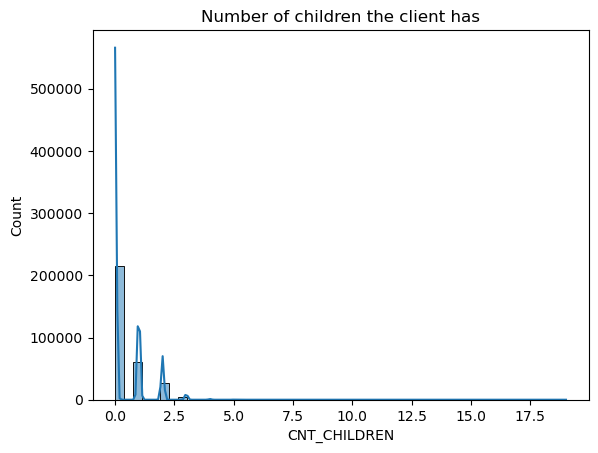

In [320]:
sns.histplot(df_train['CNT_CHILDREN'], bins=50, kde=True)
plt.title("Number of children the client has")
plt.show()

In [321]:
print(df_train['CNT_CHILDREN'].value_counts())

CNT_CHILDREN
0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
9          2
8          2
10         2
12         2
19         2
11         1
Name: count, dtype: int64


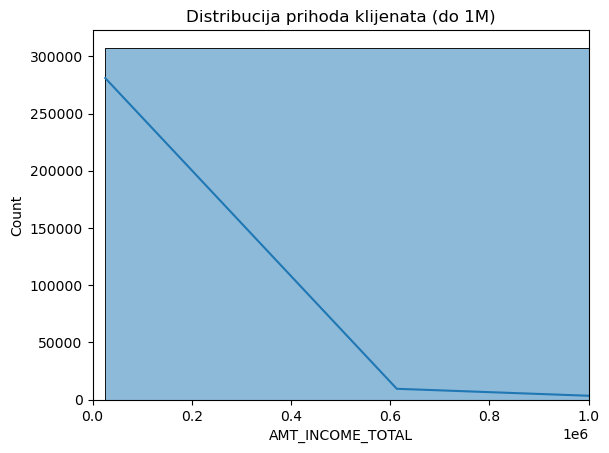

In [322]:
sns.histplot(df_train['AMT_INCOME_TOTAL'], bins=50, kde=True)
plt.xlim(0, 1_000_000)  
plt.title("Distribucija prihoda klijenata (do 1M)")
plt.show()

In [323]:
# Income of the client
df_train['AMT_INCOME_TOTAL'].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

In [324]:
# Credit amount of the loan
df_train['AMT_CREDIT'].describe()

count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

NAME_TYPE_SUITE
Unaccompanied      0.811596
Family             0.131112
Spouse, partner    0.037130
Children           0.010669
Other_B            0.005780
Other_A            0.002828
Group of people    0.000885
Name: proportion, dtype: float64


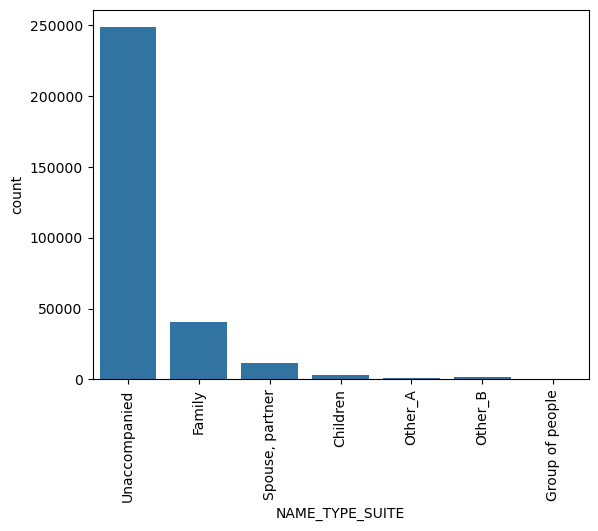

In [325]:
# Who was accompanying client when he was applying for the loan
print(df_train['NAME_TYPE_SUITE'].value_counts(normalize = True))
sns.countplot(x = 'NAME_TYPE_SUITE', data = df_train)
plt.xticks(rotation = 90)
plt.show() 

NAME_EDUCATION_TYPE
Secondary / secondary special    0.710189
Higher education                 0.243448
Incomplete higher                0.033420
Lower secondary                  0.012409
Academic degree                  0.000533
Name: proportion, dtype: float64


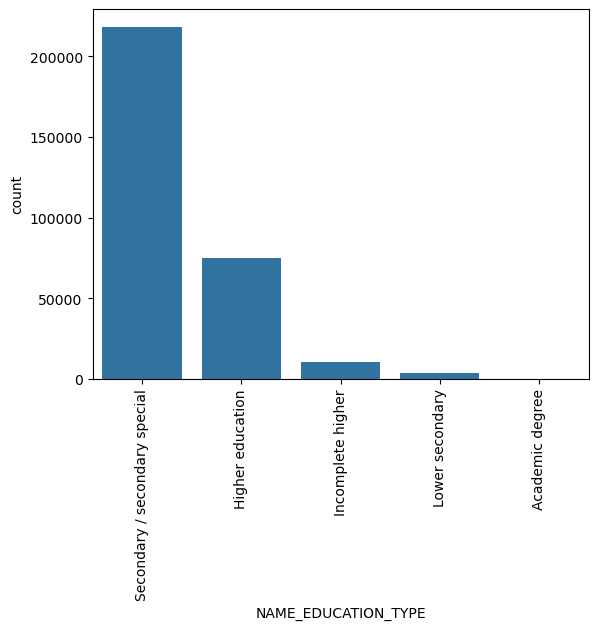

In [326]:
# Level of highest education the client achieved
print(df_train['NAME_EDUCATION_TYPE'].value_counts(normalize = True))
sns.countplot(x = 'NAME_EDUCATION_TYPE', data = df_train)
plt.xticks(rotation = 90)
plt.show() 

NAME_INCOME_TYPE
Working                 0.516320
Commercial associate    0.232892
Pensioner               0.180033
State servant           0.070576
Unemployed              0.000072
Student                 0.000059
Businessman             0.000033
Maternity leave         0.000016
Name: proportion, dtype: float64


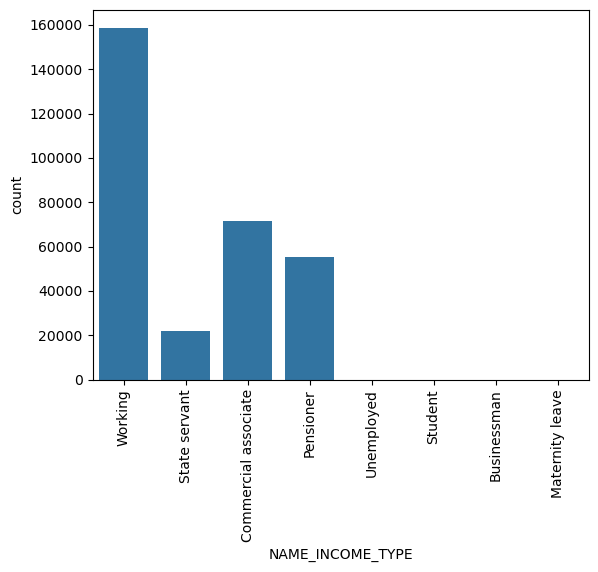

In [327]:
# Clients income type (businessman, working, maternity leave,..)
print(df_train['NAME_INCOME_TYPE'].value_counts(normalize = True))
sns.countplot(x = 'NAME_INCOME_TYPE', data = df_train)
plt.xticks(rotation = 90)
plt.show() 

In [328]:
from sklearn.preprocessing import OneHotEncoder

In [329]:
df_train.CODE_GENDER.value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

In [330]:
df_train = df_train[df_train["CODE_GENDER"] != "XNA"]

In [331]:
df_test.CODE_GENDER.value_counts()

CODE_GENDER
F    32678
M    16066
Name: count, dtype: int64

365243 - sentinel value za DAYS_EMPLOYED, klijent je možda nezaposlen, penzioner itd.

In [332]:
for df in (df_train, df_test):
    if "DAYS_EMPLOYED" in df.columns:
        df["DAYS_EMPLOYED"] = df["DAYS_EMPLOYED"].replace(365243, np.nan)

In [333]:
(df_train['DAYS_EMPLOYED'] == 365243).sum()
(df_test['DAYS_EMPLOYED'] == 365243).sum()

np.int64(0)

In [334]:
y = df_train["TARGET"].copy()
X = df_train.drop(columns=["TARGET"]).copy()

In [335]:
X

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Seconda

In [336]:
missing_pct = X.isna().mean().sort_values(ascending=False)
print("\nTop 20 kolona sa najviše NaN (%):\n", (missing_pct*100).head(20))


Top 20 kolona sa najviše NaN (%):
 COMMONAREA_AVG              69.872231
COMMONAREA_MEDI             69.872231
COMMONAREA_MODE             69.872231
NONLIVINGAPARTMENTS_AVG     69.433216
NONLIVINGAPARTMENTS_MEDI    69.433216
NONLIVINGAPARTMENTS_MODE    69.433216
FONDKAPREMONT_MODE          68.386411
LIVINGAPARTMENTS_MEDI       68.355192
LIVINGAPARTMENTS_AVG        68.355192
LIVINGAPARTMENTS_MODE       68.355192
FLOORSMIN_MODE              67.848862
FLOORSMIN_AVG               67.848862
FLOORSMIN_MEDI              67.848862
YEARS_BUILD_MODE            66.497998
YEARS_BUILD_MEDI            66.497998
YEARS_BUILD_AVG             66.497998
OWN_CAR_AGE                 65.991018
LANDAREA_MEDI               59.376860
LANDAREA_AVG                59.376860
LANDAREA_MODE               59.376860
dtype: float64


Drop kolona sa >50% NaN

In [337]:
THRESH = 0.50
high_na_cols = missing_pct[missing_pct > THRESH].index.tolist()
print(f"\nKolone za brisanje (> {int(THRESH*100)}% NaN) - broj: {len(high_na_cols)}")
print(high_na_cols)


Kolone za brisanje (> 50% NaN) - broj: 41
['COMMONAREA_AVG', 'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'FONDKAPREMONT_MODE', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE', 'FLOORSMIN_MODE', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_AVG', 'OWN_CAR_AGE', 'LANDAREA_MEDI', 'LANDAREA_AVG', 'LANDAREA_MODE', 'BASEMENTAREA_MODE', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'EXT_SOURCE_1', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_MEDI', 'ELEVATORS_MEDI', 'ELEVATORS_AVG', 'ELEVATORS_MODE', 'WALLSMATERIAL_MODE', 'APARTMENTS_AVG', 'APARTMENTS_MODE', 'APARTMENTS_MEDI', 'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'ENTRANCES_AVG', 'LIVINGAREA_AVG', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI', 'HOUSETYPE_MODE']


In [338]:
X1 = X.drop(columns=high_na_cols)
test1 = df_test.drop(columns=[c for c in high_na_cols if c in df_test.columns])

print("\nOblik TRAIN pre/posle:", X.shape, "->", X1.shape)
print("Oblik TEST  pre/posle:",  df_test.shape, "->", test1.shape)


Oblik TRAIN pre/posle: (307507, 121) -> (307507, 80)
Oblik TEST  pre/posle: (48744, 121) -> (48744, 80)


Popunjavanje NaN vrednosti - za numeričke kolone NaN se menjaju medijanom, za kategorijske kolone NaN se menjaju najčešćom vrednošću

In [339]:
from sklearn.impute import SimpleImputer

X2 = X1.copy()
test2 = test1.copy()

In [340]:
# numeričke kolone
num_cols = X2.select_dtypes(include=[np.number]).columns
imputer_num = SimpleImputer(strategy="median")

X2[num_cols] = imputer_num.fit_transform(X2[num_cols])
imputer_num.statistics_

array([ 2.78203000e+05,  0.00000000e+00,  1.47150000e+05,  5.13531000e+05,
        2.49030000e+04,  4.50000000e+05,  1.88500000e-02, -1.57500000e+04,
       -1.64800000e+03, -4.50400000e+03, -3.25400000e+03,  1.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        1.20000000e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.65961426e-01,
        5.35276250e-01,  9.81600000e-01,  1.66700000e-01,  9.81600000e-01,
        1.66700000e-01,  9.81600000e-01,  1.66700000e-01,  6.88000000e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -7.57000000e+02,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [341]:
test2[num_cols] = imputer_num.transform(test2[num_cols]) # koriste se već izračunate medijane iz imputer_num

In [342]:
# Kategorijske kolone
cat_cols = X2.select_dtypes(include=["object"]).columns
imputer_cat = SimpleImputer(strategy="most_frequent")
X2[cat_cols] = imputer_cat.fit_transform(X2[cat_cols])
test2[cat_cols] = imputer_cat.transform(test2[cat_cols])

In [343]:
print("Broj NaN nakon imputacije (train):", X2.isnull().sum().sum())
print("Broj NaN nakon imputacije (test):", test2.isnull().sum().sum())

print("Shape posle imputacije:", X2.shape, test2.shape)

Broj NaN nakon imputacije (train): 0
Broj NaN nakon imputacije (test): 0
Shape posle imputacije: (307507, 80) (48744, 80)


Low variance filter - izbacivanje kolona sa malom varijansom vrednosti, one ne pomažu modelu već mogu dodati šum, praktično su konstantne

In [344]:
desc = X2.describe().T 
low_var_cols = desc[desc['std'] < 0.005].index.tolist()
print(f"Kolone sa veoma malom varijansom (<0.005): {low_var_cols}")

Kolone sa veoma malom varijansom (<0.005): ['FLAG_MOBIL', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12']


In [345]:
X2.FLAG_MOBIL.value_counts() # Did client provide mobile phone (1=YES, 0=NO)

FLAG_MOBIL
1.0    307506
0.0         1
Name: count, dtype: int64

In [346]:
X2.FLAG_DOCUMENT_10.value_counts() # Did client provide document 10

FLAG_DOCUMENT_10
0.0    307500
1.0         7
Name: count, dtype: int64

In [347]:
X2.FLAG_DOCUMENT_12.value_counts() # Did client provide document 12

FLAG_DOCUMENT_12
0.0    307505
1.0         2
Name: count, dtype: int64

In [348]:
X3 = X2.drop(columns=low_var_cols)
test3 = test2.drop(columns=[c for c in low_var_cols if c in test2.columns])
print("Shape nakon low-variance filtera:", X3.shape, test3.shape)

Shape nakon low-variance filtera: (307507, 77) (48744, 77)


Korelacija i uklanjanje visoko-korelisanih kolona

In [349]:
# dodajem TARGET privremeno
temp = pd.concat([X3, y], axis=1)
temp_num = temp.select_dtypes(include=[np.number])

corr_matrix = temp_num.corr()

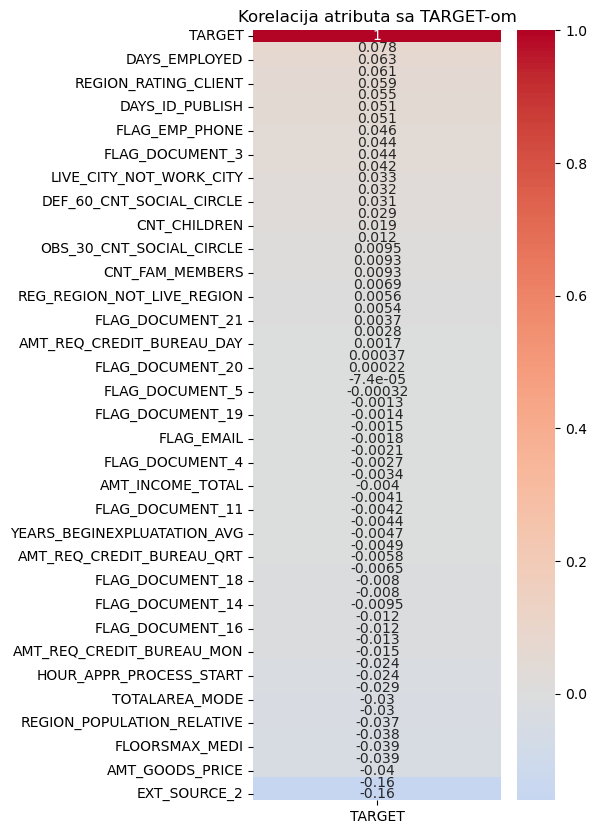

In [350]:
plt.figure(figsize=(4,10))
sns.heatmap(corr_matrix[["TARGET"]].sort_values(by="TARGET", ascending=False), 
            annot=True, cmap="coolwarm", center=0)
plt.title("Korelacija atributa sa TARGET-om")
plt.show()

In [351]:
corr_matrix

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
SK_ID_CURR,1.000000,-0.001120,-0.001821,-0.000350,-0.000438,-0.000267,0.000852,-0.001500,0.000090,-0.000973,-0.000389,-0.001332,-0.000395,0.002815,0.002769,0.000278,-0.002884,-0.001067,-0.001130,0.000354,-0.000284,0.001095,0.002901,-0.001888,-0.001588,0.000063,0.002319,0.000173,0.001074,0.003543,0.001313,0.003226,0.000942,0.003364,0.001857,-0.001417,-0.000095,-0.001431,0.001172,-0.000852,0.000700,-0.003427,-0.004139,-0.001098,0.002118,-0.002694,0.001806,0.001504,-0.002013,0.000896,-0.001078,0.002603,-0.000725,0.001450,0.000508,0.000167,0.001072,0.000282,-0.002518,-0.002066,0.001878,0.000341,0.000804,0.004073,-0.002111
CNT_CHILDREN,-0.001120,1.000000,0.012884,0.002151,0.021384,-0.001847,-0.025577,0.330937,0.026116,0.183387,-0.028014,0.240713,0.055620,-0.000794,-0.029916,0.022620,0.879159,0.025428,0.024786,-0.007303,-0.013319,0.008186,0.014836,0.020074,0.070654,0.069961,-0.018001,-0.039531,0.006401,-0.016856,0.006057,-0.016188,0.006036,-0.016603,-0.013462,0.015667,-0.001192,0.015306,-0.001796,-0.005870,0.001786,0.056848,-0.003709,-0.016736,-0.157024,-0.001498,0.051699,-0.001997,-0.005317,0.003945,-0.005459,0.003609,0.010663,0.000773,0.004031,0.000864,0.000988,-0.002450,0.000160,0.000107,-0.001082,-0.008006,-0.004908,-0.034882,0.019189
AMT_INCOME_TOTAL,-0.001821,0.012884,1.000000,0.156871,0.191657,0.159631,0.074795,0.027261,-0.021220,0.027807,0.008506,0.063994,-0.017195,-0.008290,0.000157,0.038378,0.016342,-0.085467,-0.091736,0.036459,0.031191,0.062341,0.058059,0.003574,0.006431,0.008286,0.060856,-0.030737,0.003088,0.068421,0.002563,0.065620,0.003106,0.067897,0.049423,-0.013498,-0.013464,-0.013414,-0.013327,-0.018585,-0.001000,-0.016750,0.000529,0.001507,-0.045877,0.003825,0.072451,0.018389,0.002315,0.022747,0.020708,0.010793,0.007269,0.002230,0.003130,0.002408,0.000242,-0.000589,0.001432,0.003481,0.003950,0.026748,0.007922,0.015820,-0.003982
AMT_CREDIT,-0.000350,0.002151,0.156871,1.000000,0.770126,0.986736,0.099742,-0.055434,-0.091456,0.009623,-0.006577,0.065522,-0.021072,0.023653,0.026224,0.016630,0.063167,-0.101774,-0.110913,0.052742,0.024009,0.051928,0.052608,-0.026888,-0.018860,0.000078,0.130933,0.036633,0.002089,0.089296,0.000817,0.086685,0.001769,0.088838,0.065624,0.000898,-0.020808,0.000945,-0.023395,-0.073699,0.008905,0.096357,0.000630,-0.011757,-0.046719,-0.004040,0.082818,0.022602,0.028985,0.052429,0.048828,0.032252,0.061925,0.011743,0.034329,0.021081,0.031023,-0.016148,-0.002366,0.005028,0.001633,0.055544,0.020377,-0.036630,-0.030371
AMT_ANNUITY,-0.000438,0.021384,0.191657,0.770126,1.000000,0.774837,0.118422,0.009445,-0.062350,0.038516,0.011264,0.103533,-0.024792,0.022350,0.010809,0.071705,0.075549,-0.128515,-0.141672,0.052270,0.041291,0.079402,0.074529,-0.006219,0.000890,0.010077,0.125512,0.026730,0.00694

In [352]:
# prag za visoku korelaciju
threshold = 0.7

corr_pairs = []
cols = corr_matrix.columns

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if abs(corr_matrix.iloc[i,j]) > threshold:
            corr_pairs.append((cols[i], cols[j], corr_matrix.iloc[i,j]))

print("Broj visoko-korelisanih parova:", len(corr_pairs))
print("Primeri prvih 10:", corr_pairs[:10])

Broj visoko-korelisanih parova: 15
Primeri prvih 10: [('CNT_CHILDREN', 'CNT_FAM_MEMBERS', np.float64(0.8791586577869797)), ('AMT_CREDIT', 'AMT_ANNUITY', np.float64(0.770125799275398)), ('AMT_CREDIT', 'AMT_GOODS_PRICE', np.float64(0.9867364894141368)), ('AMT_ANNUITY', 'AMT_GOODS_PRICE', np.float64(0.774836927552111)), ('REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', np.float64(0.950841651907527)), ('REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', np.float64(0.8606266975786437)), ('REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', np.float64(0.8255741759890748)), ('YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MODE', np.float64(0.9719502519247536)), ('YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MEDI', np.float64(0.993837763277884)), ('FLOORSMAX_AVG', 'FLOORSMAX_MODE', np.float64(0.9866100656684035))]


In [353]:
# kolone za brisanje
remove_cols = []
for a, b, val in corr_pairs:
    corr_a = abs(corr_matrix.loc["TARGET", a])
    corr_b = abs(corr_matrix.loc["TARGET", b])
    if corr_a < corr_b:
        remove_cols.append(a)
    else:
        remove_cols.append(b)

remove_cols = list(set(remove_cols))  

print("Kolone za brisanje:", remove_cols)

Kolone za brisanje: ['LIVE_REGION_NOT_WORK_REGION', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_CREDIT', 'REGION_RATING_CLIENT', 'FLOORSMAX_MEDI', 'YEARS_BEGINEXPLUATATION_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY', 'AMT_ANNUITY', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_MODE', 'CNT_FAM_MEMBERS']


In [354]:
X4 = X3.drop(columns=remove_cols, errors="ignore")
test4 = test3.drop(columns=[c for c in remove_cols if c in test3.columns], errors="ignore")
print("Shape nakon korelacionog filtera:", X4.shape, test4.shape)

Shape nakon korelacionog filtera: (307507, 65) (48744, 65)


feature engineering

In [355]:
X_fe = X4.copy()
test_fe = test4.copy()

In [356]:
# Godine klijenta
X_fe["AGE"] = -X_fe["DAYS_BIRTH"] / 365
test_fe["AGE"] = -test_fe["DAYS_BIRTH"] / 365

In [357]:
# Godine zaposlenja (koliko je bio zaposlen pre kredita)
X_fe["EMPLOYED_YEARS"] = -X_fe["DAYS_EMPLOYED"] / 365
test_fe["EMPLOYED_YEARS"] = -test_fe["DAYS_EMPLOYED"] / 365

In [358]:
# Odnos zaposlenosti i starosti
X_fe["EMPLOYED_AGE_RATIO"] = X_fe["DAYS_EMPLOYED"] / (X_fe["DAYS_BIRTH"]+1)
test_fe["EMPLOYED_AGE_RATIO"] = test_fe["DAYS_EMPLOYED"] / (test_fe["DAYS_BIRTH"]+1)

In [359]:
# Prihod po detetu 
X_fe["INCOME_PER_CHILD"] = X_fe["AMT_INCOME_TOTAL"] / (X_fe["CNT_CHILDREN"]+1)
test_fe["INCOME_PER_CHILD"] = test_fe["AMT_INCOME_TOTAL"] / (test_fe["CNT_CHILDREN"]+1)

In [360]:
print("Shape posle feature engineering:", X_fe.shape, test_fe.shape)

Shape posle feature engineering: (307507, 69) (48744, 69)


In [361]:
pd.set_option('display.max_rows', 100)

In [362]:
X_fe.dtypes

SK_ID_CURR                      float64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                    float64
AMT_INCOME_TOTAL                float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                      float64
DAYS_EMPLOYED                   float64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                 float64
FLAG_EMP_PHONE                  float64
FLAG_WORK_PHONE                 float64
FLAG_CONT_MOBILE                float64
FLAG_PHONE                      float64
FLAG_EMAIL                      float64
OCCUPATION_TYPE                  object
REGION_RATING_CLIENT_W_CITY     float64


In [363]:
test_fe.dtypes

SK_ID_CURR                      float64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                    float64
AMT_INCOME_TOTAL                float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                      float64
DAYS_EMPLOYED                   float64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                 float64
FLAG_EMP_PHONE                  float64
FLAG_WORK_PHONE                 float64
FLAG_CONT_MOBILE                float64
FLAG_PHONE                      float64
FLAG_EMAIL                      float64
OCCUPATION_TYPE                  object
REGION_RATING_CLIENT_W_CITY     float64


OneHotEncoding

In [364]:
all_data = pd.concat([X_fe, test_fe], axis=0)

all_data = pd.get_dummies(all_data, drop_first=True)

X_final = all_data.iloc[:len(X_fe), :].copy()
test_final = all_data.iloc[len(X_fe):, :].copy()

In [365]:
print("Final train shape:", X_final.shape)
print("Final test shape:", test_final.shape)

Final train shape: (307507, 168)
Final test shape: (48744, 168)


Spajanje sa drugim povezanim tabelama

bureau.csv

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

bureau_balance.csv

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

In [366]:
bureau = pd.read_csv('data/bureau.csv')

In [367]:
bureau.shape

(1716428, 17)

In [368]:
bureau.dtypes

SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object

In [369]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [370]:
active_clients = bureau[bureau['CREDIT_ACTIVE'] == 'Active']['SK_ID_CURR'].nunique()
print("Broj klijenata sa barem jednim aktivnim kreditom:", active_clients)

Broj klijenata sa barem jednim aktivnim kreditom: 251815


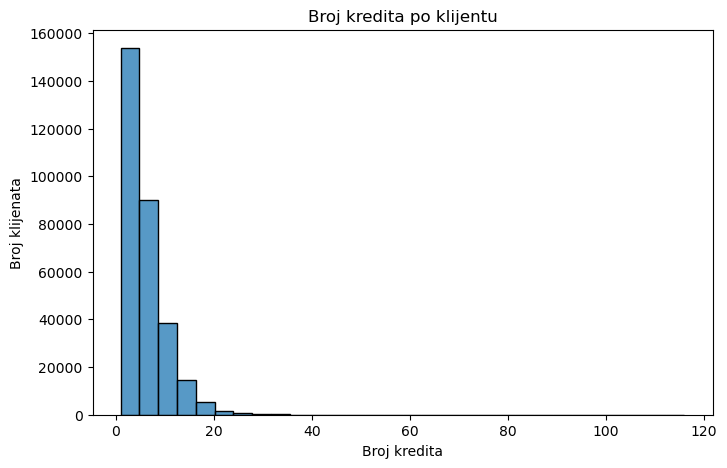

In [371]:
credits_per_client = bureau.groupby("SK_ID_CURR")['SK_ID_BUREAU'].count()
plt.figure(figsize=(8,5))
sns.histplot(credits_per_client, bins=30, kde=False)
plt.title("Broj kredita po klijentu")
plt.xlabel("Broj kredita")
plt.ylabel("Broj klijenata")
plt.show()

In [372]:
credit_type_counts = bureau['CREDIT_TYPE'].value_counts()
print("\nNajčešći tipovi kredita:")
print(credit_type_counts.head())


Najčešći tipovi kredita:
CREDIT_TYPE
Consumer credit    1251615
Credit card         402195
Car loan             27690
Mortgage             18391
Microloan            12413
Name: count, dtype: int64


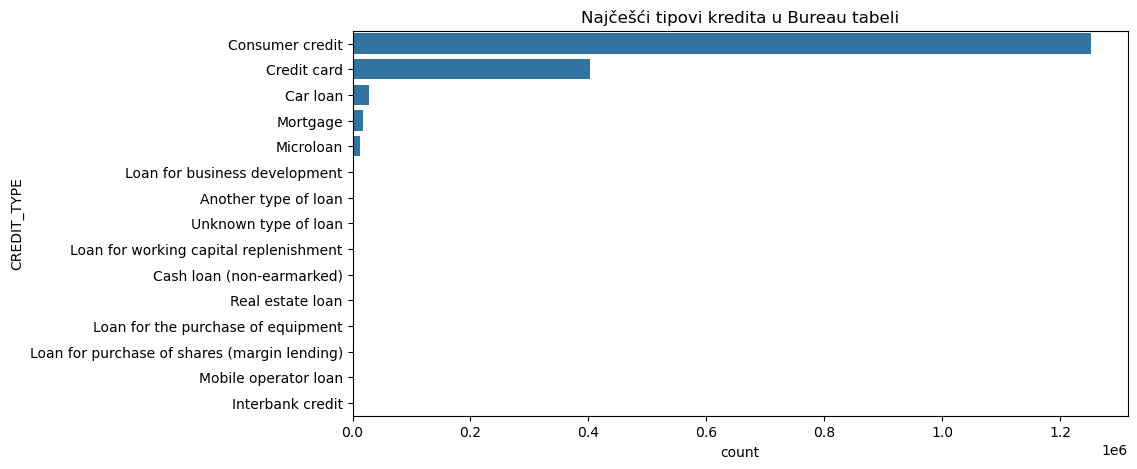

In [373]:
plt.figure(figsize=(10,5))
sns.countplot(y="CREDIT_TYPE", data=bureau, order=bureau['CREDIT_TYPE'].value_counts().index)
plt.title("Najčešći tipovi kredita u Bureau tabeli")
plt.show()

In [374]:
avg_debt = bureau['AMT_CREDIT_SUM_DEBT'].mean()
print("\nProsečna suma dugovanja (AMT_CREDIT_SUM_DEBT):", avg_debt)


Prosečna suma dugovanja (AMT_CREDIT_SUM_DEBT): 137085.11995216066


In [375]:
bb = pd.read_csv("data/bureau_balance.csv")

Svaki red predstavlja jedan mesec u istoriji datog kredita SK_ID_BUREAU

In [376]:
bb

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [377]:
status_map = {'C': 0, '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, 'X': np.nan}
bb['STATUS_ENC'] = bb['STATUS'].map(status_map)

In [378]:
bb_agg = bb.groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE': ['min','max','count'],
    'STATUS_ENC': ['mean','max']
})

In [379]:
bb_agg.columns = ["BB_" + "_".join(col).upper() for col in bb_agg.columns]

In [380]:
bureau = bureau.merge(bb_agg, on="SK_ID_BUREAU", how="left")

bureau tabela sadrži informacije o kreditima klijenata u drugim bankama. 
Svaki klijent može imati više kredita, pa se za agregaciju koristi groupby

In [381]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': ['mean', 'max', 'min'],
    'CREDIT_DAY_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['sum', 'mean', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['sum', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'BB_MONTHS_BALANCE_COUNT': ['mean','max'],
    'BB_STATUS_ENC_MEAN': ['mean'],
    'BB_STATUS_ENC_MAX': ['max']
})

In [382]:
bureau_agg.columns

MultiIndex([(            'DAYS_CREDIT', 'mean'),
            (            'DAYS_CREDIT',  'max'),
            (            'DAYS_CREDIT',  'min'),
            (     'CREDIT_DAY_OVERDUE', 'mean'),
            (     'CREDIT_DAY_OVERDUE',  'max'),
            (         'AMT_CREDIT_SUM',  'sum'),
            (         'AMT_CREDIT_SUM', 'mean'),
            (         'AMT_CREDIT_SUM',  'max'),
            (    'AMT_CREDIT_SUM_DEBT',  'sum'),
            (    'AMT_CREDIT_SUM_DEBT', 'mean'),
            (     'CNT_CREDIT_PROLONG',  'sum'),
            ('BB_MONTHS_BALANCE_COUNT', 'mean'),
            ('BB_MONTHS_BALANCE_COUNT',  'max'),
            (     'BB_STATUS_ENC_MEAN', 'mean'),
            (      'BB_STATUS_ENC_MAX',  'max')],
           )

DAYS_CREDIT: How many days before current application did client apply for Credit Bureau credit (kada je otvoren kredit)
CREDIT_DAY_OVERDUE: Number of days past due on CB credit at the time of application for related loan in our sample (koliko dana kasni)
AMT_CREDIT_SUM: Current credit amount for the Credit Bureau credit (ukupna suma kredita)
AMT_CREDIT_SUM_DEBT: Current debt on Credit Bureau credit (suma dugovanja)
CNT_CREDIT_PROLONG: How many times was the Credit Bureau credit prolonged (broj puta produžen kredit)
BB_MONTHS_BALANCE_COUNT: broj meseci istorije kredita koji postoji u bureau_balance za neki kredit
BB_STATUS_ENC_MEAN: prosečna vrednost enkodiranog statusa jednog kredita kroz sve mesece
BB_STATUS_ENC_MAX: maksimalna vrednost enkodiranog statusa jednog kredita kroz sve mesece (što veća to je gore)

In [383]:
bureau_agg.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

In [384]:
bureau_categorical = pd.get_dummies(bureau[['SK_ID_CURR', 'CREDIT_ACTIVE', 'CREDIT_TYPE']], drop_first=True)
bureau_cat_agg = bureau_categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])

bureau_cat_agg.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_cat_agg.columns.tolist()])

In [385]:
bureau_full_agg = bureau_agg.join(bureau_cat_agg, how='left', on='SK_ID_CURR')

In [386]:
X_final = X_final.join(bureau_full_agg, how='left', on='SK_ID_CURR')
test_final = test_final.join(bureau_full_agg, how='left', on='SK_ID_CURR')

In [387]:
X_final.fillna(0, inplace=True)
test_final.fillna(0, inplace=True)

print("Shape nakon spajanja sa bureau podacima:")
print("Train:", X_final.shape)
print("Test:", test_final.shape)

Shape nakon spajanja sa bureau podacima:
Train: (307507, 217)
Test: (48744, 217)


previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

In [388]:
previous_app = pd.read_csv('data/previous_application.csv')

In [389]:
previous_app.shape

(1670214, 37)

In [390]:
apps_per_client = previous_app.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
apps_per_client

SK_ID_CURR
100001    1
100002    1
100003    3
100004    1
100005    2
         ..
456251    1
456252    1
456253    2
456254    2
456255    8
Name: SK_ID_PREV, Length: 338857, dtype: int64

In [391]:
status_counts = previous_app['NAME_CONTRACT_STATUS'].value_counts()
status_counts

NAME_CONTRACT_STATUS
Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: count, dtype: int64

In [392]:
previous_app['YEARS_SINCE_DECISION'] = -previous_app['DAYS_DECISION']/365

In [393]:
previous_app['YEARS_SINCE_DECISION']

0          0.200000
1          0.449315
2          0.824658
3          1.402740
4          2.139726
             ...   
1670209    1.490411
1670210    4.641096
1670211    4.076712
1670212    3.246575
1670213    3.268493
Name: YEARS_SINCE_DECISION, Length: 1670214, dtype: float64

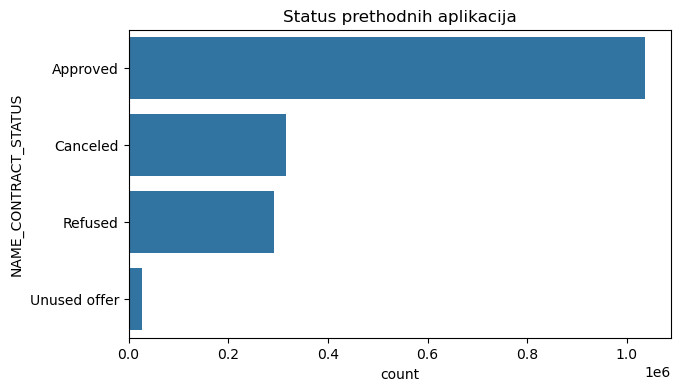

In [394]:
plt.figure(figsize=(7,4))
sns.countplot(y='NAME_CONTRACT_STATUS', data=previous_app,
              order=previous_app['NAME_CONTRACT_STATUS'].value_counts().index)
plt.title('Status prethodnih aplikacija')
plt.show()

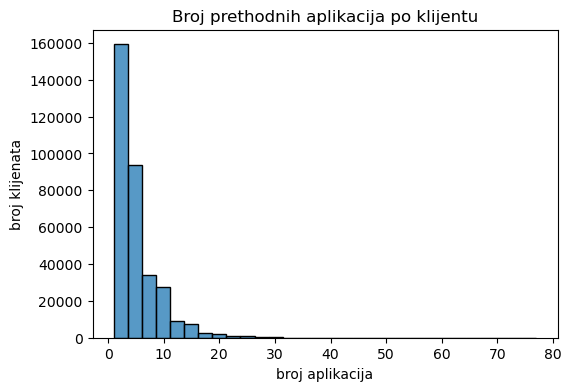

In [395]:
plt.figure(figsize=(6,4))
sns.histplot(apps_per_client, bins=30)
plt.title('Broj prethodnih aplikacija po klijentu')
plt.xlabel('broj aplikacija'); plt.ylabel('broj klijenata')
plt.show()

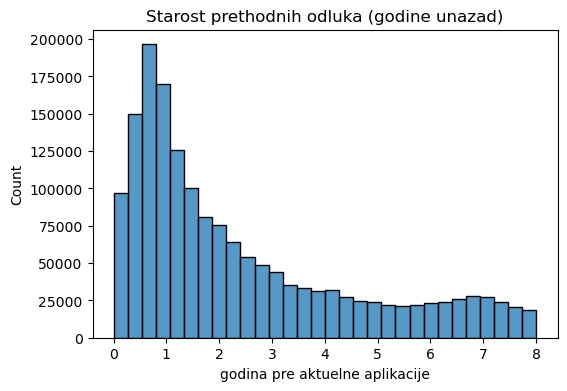

In [396]:
plt.figure(figsize=(6,4))
sns.histplot(previous_app['YEARS_SINCE_DECISION'], bins=30)
plt.title('Starost prethodnih odluka (godine unazad)')
plt.xlabel('godina pre aktuelne aplikacije')
plt.show()

In [397]:
installments = pd.read_csv('data/installments_payments.csv')
pos_cash = pd.read_csv('data/POS_CASH_balance.csv')
cc_balance = pd.read_csv('data/credit_card_balance.csv')

installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.

POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.

credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.

In [398]:
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [399]:
# Ako je DAYS_ENTRY_PAYMENT > DAYS_INSTALMENT platio je kasnije nego sto je trebalo
installments['LATE_DAYS'] = (installments['DAYS_ENTRY_PAYMENT'] - installments['DAYS_INSTALMENT']).clip(lower=0)
# Ako je AMT_PAYMENT < AMT_INSTALMENT platio je manje nego sto je trebalo
installments['PAYMENT_RATIO'] = installments['AMT_PAYMENT'] / (installments['AMT_INSTALMENT'] + 1e-5)

In [400]:
inst_agg = installments.groupby('SK_ID_PREV').agg({
    'LATE_DAYS': ['mean','max'],
    'PAYMENT_RATIO': ['mean','min']
})

In [401]:
inst_agg.columns = ['INST_' + '_'.join(c).upper() for c in inst_agg.columns]

In [402]:
pos_cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


MONTHS_BALANCE: Month of balance relative to application date (-1 means the information to the freshest monthly snap...
SK_DPD: DPD (days past due) during the month of previous credit (koliko je kasnio)
SK_DPD_DEF: DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit (isto kao prethodno samo male dugove ignorise)

In [403]:
pos_agg = pos_cash.groupby('SK_ID_PREV').agg({
    'MONTHS_BALANCE': ['min','max','count'],
    'SK_DPD': ['mean','max'],   # days past due
    'SK_DPD_DEF': ['mean','max']
})
pos_agg.columns = ['POS_' + '_'.join(c).upper() for c in pos_agg.columns]

In [404]:
cc_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [405]:
cc_balance['UTILIZATION'] = cc_balance['AMT_BALANCE'] / (cc_balance['AMT_CREDIT_LIMIT_ACTUAL'] + 1e-5)

AMT_BALANCE: Balance during the month of previous credit
AMT_CREDIT_LIMIT_ACTUAL: Credit card limit during the month of the previous credit
UTILIZATION: iskoriscenost

In [406]:
cc_agg = cc_balance.groupby('SK_ID_PREV').agg({
    'AMT_BALANCE': ['mean','max'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['mean','max'],
    'UTILIZATION': ['mean','max']
})
cc_agg.columns = ['CC_' + '_'.join(c).upper() for c in cc_agg.columns]

In [407]:
previous_app = previous_app.merge(inst_agg, on='SK_ID_PREV', how='left')
previous_app = previous_app.merge(pos_agg, on='SK_ID_PREV', how='left')
previous_app = previous_app.merge(cc_agg, on='SK_ID_PREV', how='left')

In [408]:
prev_app_agg = previous_app.groupby('SK_ID_CURR').agg({
    'AMT_ANNUITY': ['mean', 'max', 'sum'],
    'AMT_CREDIT': ['mean', 'max', 'sum'],
    'DAYS_DECISION': ['mean', 'max', 'min'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'INST_LATE_DAYS_MEAN': ['mean'],
    'INST_LATE_DAYS_MAX': ['max'],
    'INST_PAYMENT_RATIO_MEAN': ['mean'],
    'POS_MONTHS_BALANCE_COUNT': ['mean'],
    'POS_SK_DPD_MAX': ['max'],
    'CC_UTILIZATION_MEAN': ['mean'],
    'CC_UTILIZATION_MAX': ['max']
})

AMT_ANNUITY: Loan annuity (rate iz prethodnih aplikacija)
AMT_CREDIT: Credit amount of the loan 
DAYS_DECISION: dani u odnosu na trenutnu aplikaciju (negativni = u prošlosti)
CNT_PAYMENT: planirani broj rata prethodnih kredita

In [409]:
prev_app_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_app_agg.columns.tolist()])

In [410]:
prev_app_categorical = pd.get_dummies(previous_app[['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'NAME_CLIENT_TYPE', 'NAME_CONTRACT_STATUS']], drop_first=True)
prev_app_cat_agg = prev_app_categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])

prev_app_cat_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_app_cat_agg.columns.tolist()])

In [411]:
prev_full_agg = prev_app_agg.join(prev_app_cat_agg, how='left', on='SK_ID_CURR')

X_final = X_final.join(prev_full_agg, how='left', on='SK_ID_CURR')
test_final = test_final.join(prev_full_agg, how='left', on='SK_ID_CURR')

In [412]:
X_final.fillna(0, inplace=True)
test_final.fillna(0, inplace=True)

In [413]:
print("\nShape nakon spajanja sa previous_application podacima:")
print("Train:", X_final.shape)
print("Test:", test_final.shape)


Shape nakon spajanja sa previous_application podacima:
Train: (307507, 253)
Test: (48744, 253)


Modelovanje

In [414]:
# X_final delim na:
X_train, X_val, y_train, y_val = train_test_split(X_final, y, test_size=0.2, stratify=y, random_state=42)

In [415]:
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Train shape: (246005, 253)
Validation shape: (61502, 253)


In [416]:
def evaluate_model(model, X_val, y_val, model_name="Model"):
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:,1]
    
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_proba)
    cm = confusion_matrix(y_val, y_pred)
    
    print(f"\nConfusion Matrix for {model_name}:\n{cm}")
    
    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "ROC-AUC": roc_auc}

Logistic Regression

In [417]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [418]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

log_reg = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42, n_jobs=-1)
log_reg.fit(X_train_scaled, y_train)

results_logreg = evaluate_model(log_reg, X_val_scaled, y_val)


Confusion Matrix for Model:
[[39351 17186]
 [ 1561  3404]]


In [419]:
results_logreg

{'Accuracy': 0.6951806445318851,
 'Precision': 0.16532297231665857,
 'Recall': 0.6855991943605236,
 'F1': 0.2664057914302485,
 'ROC-AUC': 0.7582697788956962}

Hiperparametri za log. reg.

In [422]:
print(log_reg.get_params())

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 2000, 'multi_class': 'deprecated', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Feature importance za log. reg.

In [423]:
feat_names = X_train.columns 
coefs = log_reg.coef_.ravel()
top_pos = np.argsort(coefs)[-10:][::-1]
top_neg = np.argsort(coefs)[:10]

In [424]:
print("LR: Top + feature-i:")
for i in top_pos: print(feat_names[i], coefs[i])
print("\nLR: Top - feature-i:")
for i in top_neg: print(feat_names[i], coefs[i])

LR: Top + feature-i:
FLAG_DOCUMENT_3 0.23678258380438483
PREV_CNT_PAYMENT_MEAN 0.2090562153516177
CODE_GENDER_M 0.19524863608234908
BUREAU_CREDIT_TYPE_Consumer credit_SUM 0.15213981709858226
FLAG_DOCUMENT_6 0.14186858781565795
PREV_NAME_CONTRACT_STATUS_Refused_MEAN 0.13483161476463962
PREV_AMT_CREDIT_MAX 0.1234644401922837
OCCUPATION_TYPE_Laborers 0.12029848261471539
PREV_INST_LATE_DAYS_MEAN_MEAN 0.11611403025600486
PREV_CNT_PAYMENT_SUM 0.09903956095990495

LR: Top - feature-i:
EXT_SOURCE_3 -0.4114182431329791
EXT_SOURCE_2 -0.3885912451298199
BUREAU_CREDIT_ACTIVE_Closed_SUM -0.24484478334900836
PREV_AMT_CREDIT_MEAN -0.11300213699536525
PREV_NAME_CLIENT_TYPE_Repeater_MEAN -0.10810294852030655
FLAG_OWN_CAR_Y -0.10779008969123276
BUREAU_CREDIT_TYPE_Credit card_MEAN -0.10051197545852025
BUREAU_CREDIT_TYPE_Consumer credit_MEAN -0.09373195377956153
BUREAU_DAYS_CREDIT_MAX -0.0805712220659857
PREV_NAME_CONTRACT_TYPE_Consumer loans_SUM -0.07966598613719436


In [420]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight="balanced", random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
results_rf = evaluate_model(rf, X_val, y_val)


Confusion Matrix for Model:
[[43376 13161]
 [ 2060  2905]]


In [421]:
results_rf

{'Accuracy': 0.7525121134272056,
 'Precision': 0.1808166313954936,
 'Recall': 0.5850956696878147,
 'F1': 0.27625885597451383,
 'ROC-AUC': 0.7467254491221526}

In [425]:
print("RandomForest params:", rf.get_params())

RandomForest params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [426]:
importances = rf.feature_importances_
feat_names = X_train.columns
indices = np.argsort(importances)[::-1]

In [427]:
print("Top 10 feature-a po važnosti (Gini importance):")
for i in range(10):
    print(f"{feat_names[indices[i]]}: {importances[indices[i]]:.4f}")

Top 10 feature-a po važnosti (Gini importance):
EXT_SOURCE_2: 0.1236
EXT_SOURCE_3: 0.1100
BUREAU_DAYS_CREDIT_MEAN: 0.0365
DAYS_EMPLOYED: 0.0297
EMPLOYED_YEARS: 0.0292
BUREAU_CREDIT_ACTIVE_Closed_MEAN: 0.0261
AGE: 0.0235
DAYS_BIRTH: 0.0232
PREV_INST_LATE_DAYS_MEAN_MEAN: 0.0224
PREV_NAME_CONTRACT_STATUS_Refused_MEAN: 0.0210


In [ ]:
RandomizedSearchCV tuning pipeline za XGBoost

In [431]:
from xgboost.sklearn import XGBClassifier

In [432]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

param_grid = {
    "n_estimators": [200, 400, 600],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1],
}

Ključni hiperparametri xgboost-a koje ću isprobati (broj stabala, dubina, stopa učenja, subsample itd.)

In [433]:
xgb_for_tuning = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    max_bin=256,
    random_state=42,
    n_jobs=-1,
    eval_metric="auc",
    verbosity=0,
    early_stopping_rounds=50  
)

osnovni model: binarna klasifikacija, koristi histogram split (brže), meri AUC, ima early stopping..

In [434]:
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
# deli train na 2 folda, čuva proporciju klasa. Tako testiraš svaki skup parametara na različitim podelama.

random_search = RandomizedSearchCV(
    estimator=xgb_for_tuning,
    param_distributions=param_grid,
    n_iter=5,
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
# umesto da testira sve kombinacije (GridSearch), on testira 5 slučajnih kombinacija.

In [435]:
fit_params = {
    'eval_set': [(X_val.astype(np.float32), y_val)]
}

random_search.fit(
    X_train.astype(np.float32),
    y_train,
    **fit_params  
)
# pratila AUC na validation setu radi early stopping-a

print("Najbolji parametri:", random_search.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


[0]	validation_0-auc:0.68674
[1]	validation_0-auc:0.69137
[2]	validation_0-auc:0.69495
[3]	validation_0-auc:0.70092
[4]	validation_0-auc:0.70666
[5]	validation_0-auc:0.70771
[6]	validation_0-auc:0.70825
[7]	validation_0-auc:0.71178
[8]	validation_0-auc:0.71247
[9]	validation_0-auc:0.71484
[10]	validation_0-auc:0.71655
[11]	validation_0-auc:0.71741
[12]	validation_0-auc:0.71859
[13]	validation_0-auc:0.71998
[14]	validation_0-auc:0.72203
[15]	validation_0-auc:0.72295
[16]	validation_0-auc:0.72466
[17]	validation_0-auc:0.72681
[18]	validation_0-auc:0.72832
[19]	validation_0-auc:0.72857
[20]	validation_0-auc:0.72969
[21]	validation_0-auc:0.73121
[22]	validation_0-auc:0.73358
[23]	validation_0-auc:0.73446
[24]	validation_0-auc:0.73597
[25]	validation_0-auc:0.73641
[26]	validation_0-auc:0.73819
[27]	validation_0-auc:0.73897
[28]	validation_0-auc:0.73987
[29]	validation_0-auc:0.74100
[30]	validation_0-auc:0.74186
[31]	validation_0-auc:0.74276
[32]	validation_0-auc:0.74386
[33]	validation_0-au

Najbolji parametri: {'subsample': 1.0, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}
Svaka kombinacija je trenirana i evaluirana na validation setu (eval_set) i pratila se metrika AUC (eval_metric = "auc"). Ova dobijena kombinacija je najbolja kombinacija jer je dala najbolji prosek AUC-a u cross-validaciji.

In [436]:
best_xgb = random_search.best_estimator_ # vraca model istreniran sa najboljim parametrima
results_best_xgb = evaluate_model(best_xgb, X_val, y_val, "Tuned XGBoost")
print("\nRezultati XGBoost modela nakon podešavanja parametara:")
print(results_best_xgb)


Confusion Matrix for Tuned XGBoost:
[[56428   109]
 [ 4805   160]]

Rezultati XGBoost modela nakon podešavanja parametara:
{'Accuracy': 0.9201001593444116, 'Precision': 0.5947955390334573, 'Recall': 0.032225579053373615, 'F1': 0.061138708444784105, 'ROC-AUC': 0.7744288641570997}


In [437]:
results_df = pd.DataFrame([results_logreg, results_rf, results_best_xgb],
                          index=["Logistic Regression", "Random Forest", "XGBoost"])
print(results_df)

                     Accuracy  Precision    Recall        F1   ROC-AUC
Logistic Regression  0.695181   0.165323  0.685599  0.266406  0.758270
Random Forest        0.752512   0.180817  0.585096  0.276259  0.746725
XGBoost              0.920100   0.594796  0.032226  0.061139  0.774429


XGBoost je najbolji model od korišćenih jer daje najveći ROC/AUC i ukupnu tačnost, pa ga koristim za finalne predikcije. Sledeći logičan korak bi bio optimizacija praga verovatnoće (npr. pomoću ROC krive ili PR krive), što bi poboljšalo Recall i F1 skor

Pošto je ciljna klasa nebalansirana, default prag od 0.5 daje nizak Recall. Optimizacijom praga na osnovu F1 skor-a dobija se znatno bolji balans između Precision i Recall

In [438]:
from sklearn.metrics import precision_recall_curve, f1_score

y_proba = best_xgb.predict_proba(X_val.astype(np.float32))[:,1]
prec, rec, thresholds = precision_recall_curve(y_val, y_proba)

In [439]:
# F1 optimizacija
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

In [440]:
print("Najbolji prag po F1:", best_threshold)
print("Precision:", prec[best_idx])
print("Recall:", rec[best_idx])
print("F1:", f1_scores[best_idx])

Najbolji prag po F1: 0.16076198
Precision: 0.2681759379042691
Recall: 0.4175226586102719
F1: 0.32658479351086844


Ako model misli da postoji makar 16% sanse da klijent nece otplatiti, ja ga vec klasifikujem kao rizicnog.

In [441]:
y_pred_new = (y_proba >= best_threshold).astype(int)
print(classification_report(y_val, y_pred_new))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     56537
           1       0.27      0.42      0.33      4965

    accuracy                           0.86     61502
   macro avg       0.61      0.66      0.62     61502
weighted avg       0.89      0.86      0.87     61502



Ranije je Recall bio 3% a sada je 42%.

In [443]:
best_xgb.set_params(early_stopping_rounds=None)
best_xgb.fit(X_final.astype("float32"), y.astype(int)) # najbolji model treniram na svim trening podacima (bez val. podele)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [444]:
test_proba = best_xgb.predict_proba(test_final.astype("float32"))[:, 1] # posto se na kaggle salje verovatnoca (kolona target) za svaki SK_ID_CURR

In [449]:
submission = pd.DataFrame({
    "SK_ID_CURR": test_ids, 
    "TARGET": test_proba
})
submission.to_csv("submission.csv", index=False)
print("submission.csv je napravljen")

submission.csv je napravljen
